## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [310]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

DBG = False
CB_X = 6
CB_Y = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((CB_X * CB_Y, 3), np.float32)
objp[:,:2] = np.mgrid[0 : CB_Y, 0 : CB_X].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (CB_Y, CB_X), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (CB_Y, CB_X), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

## Apply a distortion correction to raw images

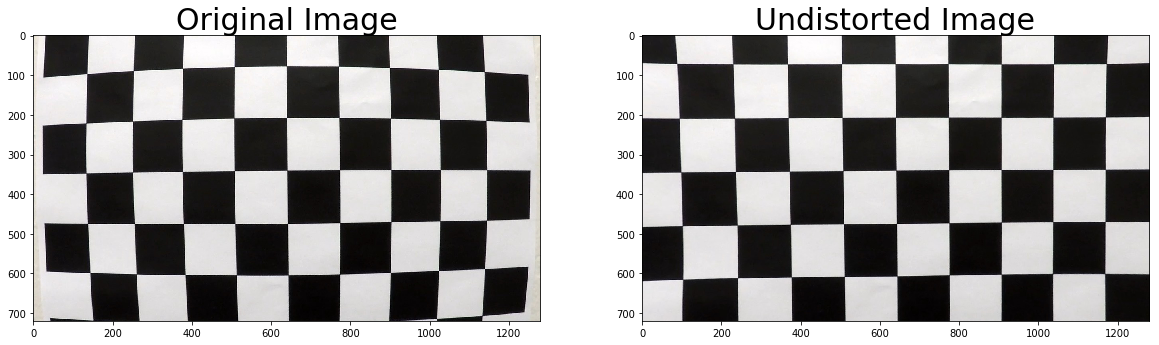

In [311]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Find camera calibration parameters given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                   imgpoints,
                                                   img_size,
                                                   None,
                                                   None)

# Helper function to undistort images
def undistort(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
dst = undistort(img)
#cv2.imwrite('output_images/test_undist.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Use color transforms, gradients, etc., to create a thresholded binary image.

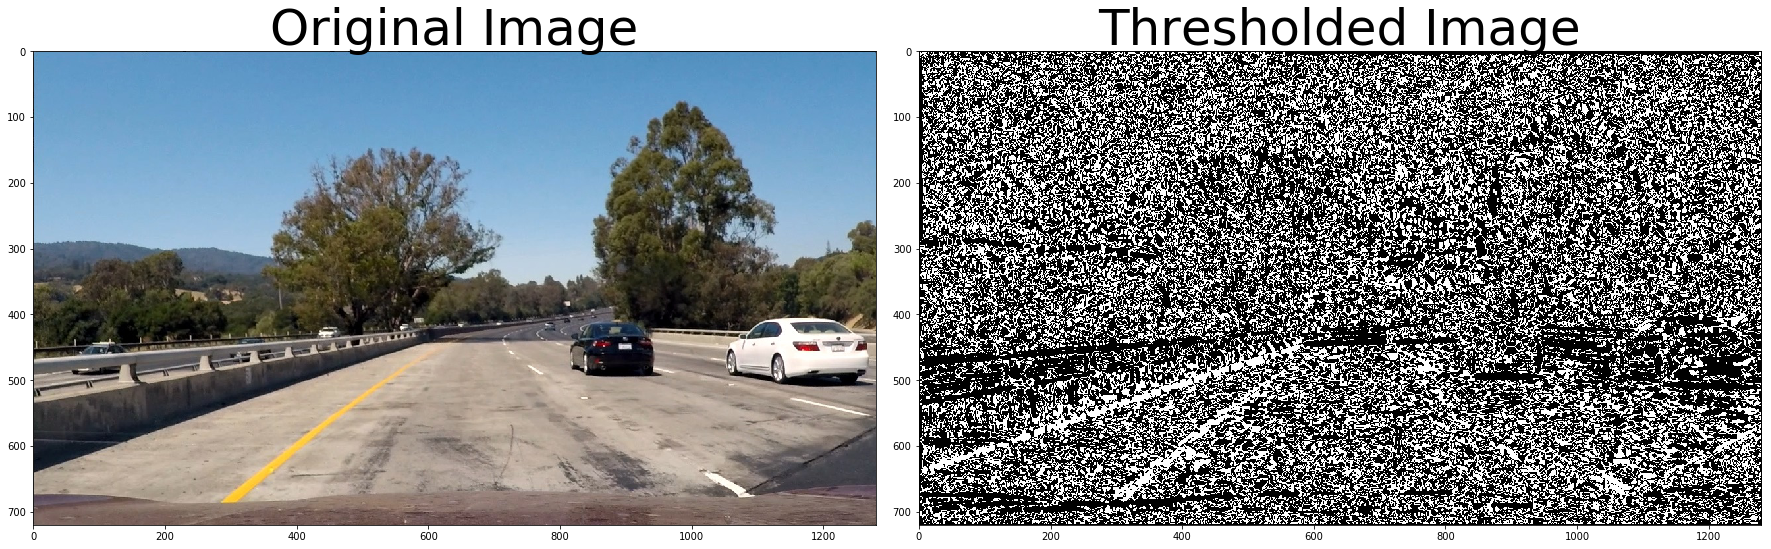

In [312]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image
image = mpimg.imread('test_images/test1.jpg')

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_mag = np.uint8(255*mag/np.max(mag))
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    dir = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(dir, dtype=np.uint8)
    binary_output[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    return binary_output
    
# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
dir_binary = dir_thresh(image, sobel_kernel=15, thresh=(0.7, 1.3)) #thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

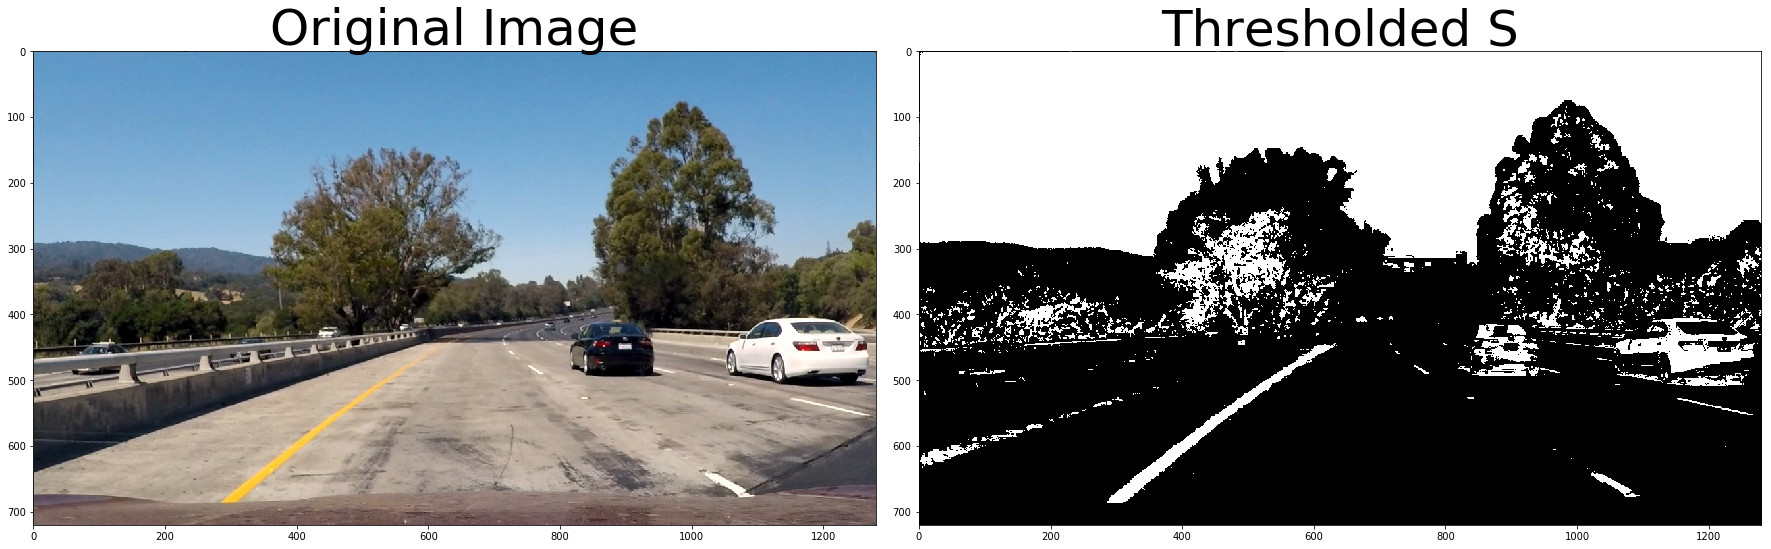

In [313]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in an image, you can also try test1.jpg or test4.jpg
image = mpimg.imread('test_images/test1.jpg') 

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary
    
hls_binary = hls_select(image, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

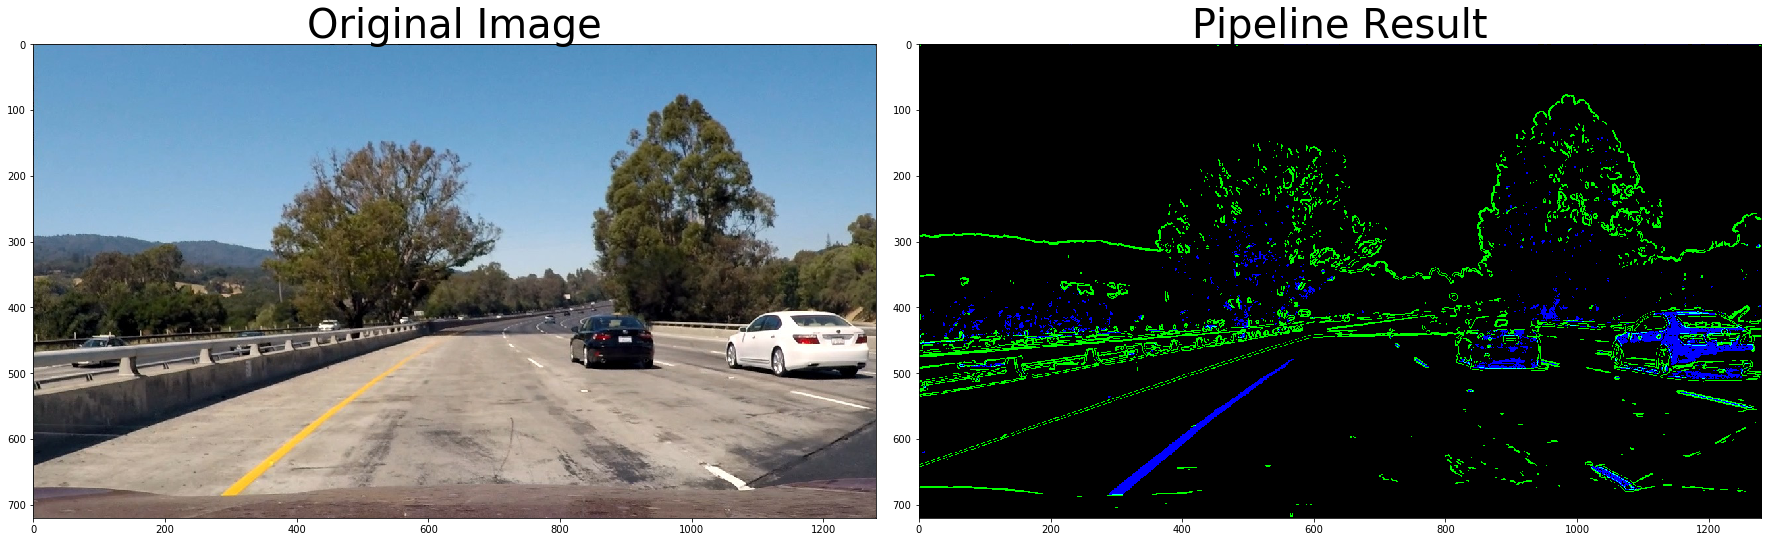

In [314]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread('test_images/test1.jpg')

# Edit this function to create your own pipeline.
def make_binary(img, mg_thresh=(50, 100), s_thresh=(180, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Threshold color channel
    s_binary = hls_select(img, s_thresh)
    
    # Threshold sobel magnitude   
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=mg_thresh)
         
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(mag_binary), mag_binary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(mag_binary)
    combined_binary[(s_binary == 1) | (mag_binary == 1)] = 1
    return (combined_binary, color_binary)
    
(comb_bin, col_bin) = make_binary(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

res = col_bin
ax2.imshow(res)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Apply a perspective transform to rectify binary image ("birds-eye view")

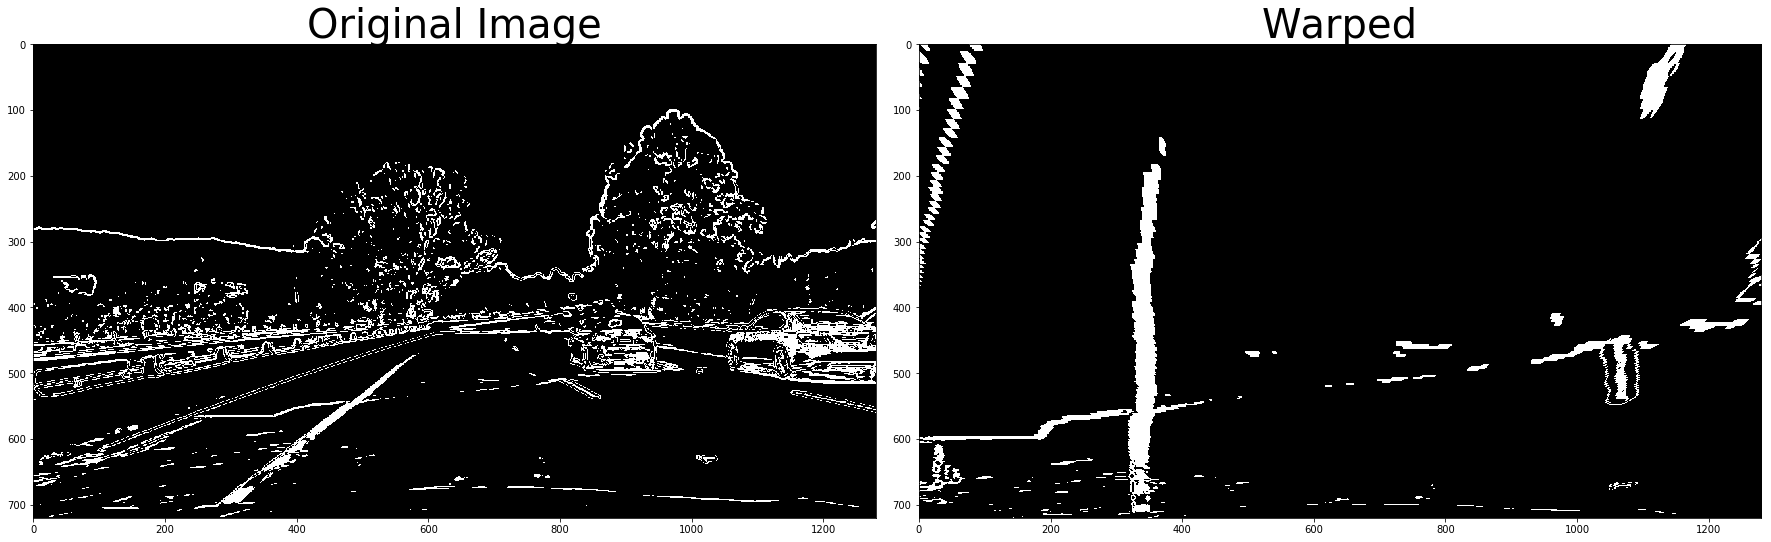

In [320]:
def perspective_transform(img):  
    src_corners = [[195, img_size[1]], # left bottom
                   [580, 460], # left top
                   [705, 460], # right top
                   [1105, img_size[1]]] # right bottom
    
    dst_corners = [[280, img_size[1]], [280, 0], [1000, 0], [1000, img_size[1]]]
    #warped = img
    
    src = np.float32(src_corners)
    dst = np.float32(dst_corners)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img,
                                 M,
                                 (img.shape[1], img.shape[0]),
                                 flags=cv2.INTER_LINEAR)
    
    
    if DBG:
        cv2.polylines(img,
                      [np.array(src_corners,dtype=np.int32).reshape((-1, 1, 2))],
                      True,
                      (255,255,0),
                      thickness = 2)
        cv2.polylines(warped,
                      [np.array(dst_corners, dtype=np.int32).reshape((-1, 1, 2))],
                      True,
                      (255,255,0),
                      thickness=2)
    return (img, warped)

(img, warped) = perspective_transform(comb_bin)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(comb_bin, cmap=plt.cm.gray)
ax1.set_title('Original Image', fontsize=40)

res = col_bin
ax2.imshow(warped, cmap=plt.cm.gray)
ax2.set_title('Warped', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Detect lane pixels and fit to find the lane boundary.

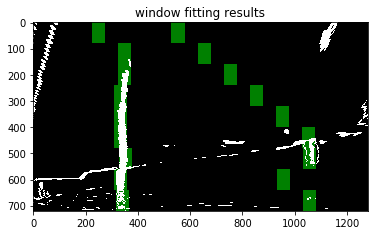

In [321]:
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

## Pipeline

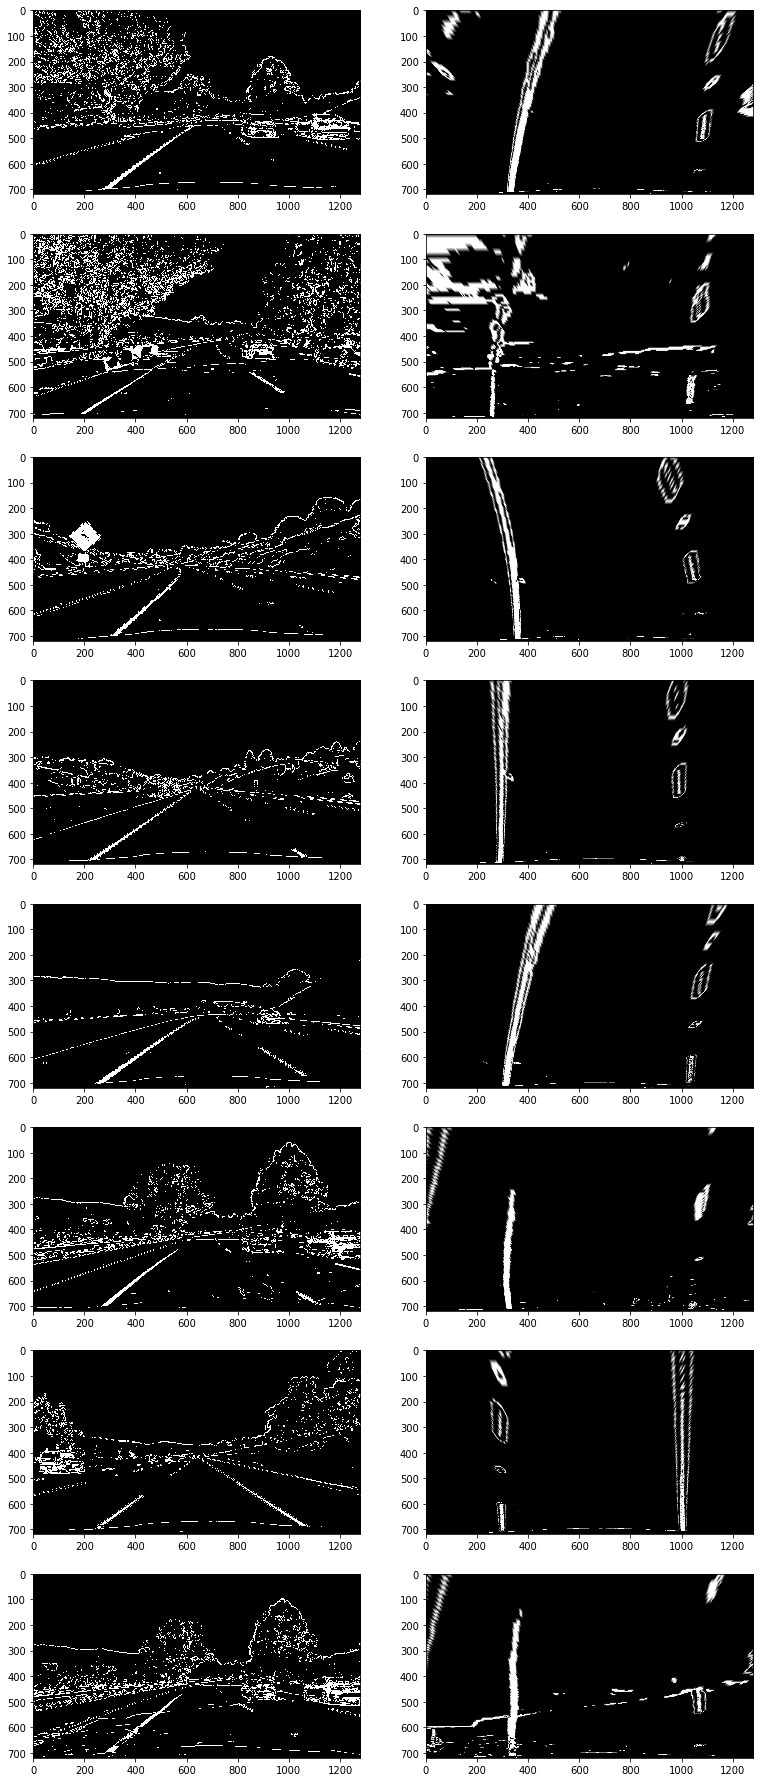

In [316]:
import os

# Make a list of images
images = glob.glob('test_images/*.jpg')
images_count = len(images)
fig, ax = plt.subplots(images_count, 2, figsize=(10, 27))


# Step through the list
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    
    # Get base name
    base = os.path.basename(fname)
    base = os.path.splitext(base)[0]
    
    # Undistort
    und = undistort(img)    
    cv2.imwrite('output_images/undist_' + base + '.jpg', und)
    
    # Make binary
    (comb_bin, col_bin) = make_binary(und)
    colored = np.dstack((comb_bin, comb_bin, comb_bin)) * 255
    cv2.imwrite('output_images/bin_' + base + '.jpg', cv2.cvtColor(col_bin, cv2.COLOR_RGB2BGR))
    
    # Perspective transform
    (colored, res) = perspective_transform(colored)
    cv2.imwrite('output_images/warped_' + base + '.jpg', cv2.cvtColor(colored, cv2.COLOR_RGB2BGR))
    
    ax[idx, 0].imshow(colored)
    ax[idx, 1].imshow(res)
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)